TSORMPATZOGLOU IOANNIS

NTUA, HEP

PyHEADTAIL Simulation Framework

# MULTI-BUNCH TRACKING WITH SHM, BEAM-BEAM KICK, AND SPACE CHARGE

This is the most advanced version of our particle tracking simulation. It extends the previous setups by including 
three physical effects:

1. Simple Harmonic Motion (SHM) – linear focusing with restoring force F = -k·x.

2. Beam-beam interactions (Bassetti-Erskine kick) – non-linear electromagnetic force due to the opposing Gaussian bunch.

3. (New!) Space charge effect – collective self-field of the bunch affecting transverse dynamics, calculated using PyHEADTAIL's TransverseGaussianSpaceCharge module.

We keep the same linear focusing constant k as in previous versions to maintain consistency and to clearly observe how 
adding beam-beam and space charge modifies the dynamics.

Key goals:

1. Compare the centroid motion and phase-space distribution to previous versions (SHM-only and SHM+beam-beam).

2. Understand the combined effects of non-linear beam-beam forces and collective space charge forces.

3. Analyze RMS beam size, transverse emittance, and momentum kicks.

## This version is fully multi-dimensional: transverse coordinates x, y, conjugate momenta xp, yp, as well as longitudinal coordinate z and relative momentum deviation δ are included. The bunch is sliced longitudinally to properly compute space charge effects.

# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PyHEADTAIL
import matplotlib.animation as animation
from PyHEADTAIL.particles import Particles
from scipy.special import wofz
import PyHEADTAIL.spacecharge.spacecharge as SC
from PyHEADTAIL.spacecharge.spacecharge import TransverseGaussianSpaceCharge
from PyHEADTAIL.particles.slicing import UniformBinSlicer

PyHEADTAIL v1.16.5


# Physics functions

In [2]:
def apply_kick_SHM(x, xp, k):
    """
    Apply linear restoring force kick (SHM): Δxp = -k * x.
    This models a quadrupole-like focusing in the transverse plane.
    """
    xp -= k * x
    return xp

def update_position(x, xp, dz=1):
    """
    Update transverse position by drift: x_new = x_old + xp * dz.
    Discrete approximation of dx/dz = x'.
    """
    x += xp * dz
    return x

def bassetti_erskine(x, y, sigma_x, sigma_y):
    """
    Compute complex kick due to Gaussian beam using Bassetti-Erskine formula.
    Returns (Δx', Δy') contribution per particle.
    - Circular beam: sigma_x = sigma_y.
    - Elliptical beam: sigma_x ≠ sigma_y.
    Uses the Faddeeva function w(z).
    """
    if sigma_x == sigma_y:
       z = (x + 1j * y) / (np.sqrt(2) * sigma_x)
       w = wofz(z)
       return np.real(w), np.imag(w)
    else:
       z = (x + 1j * y) / (np.sqrt(2 * (sigma_x**2 - sigma_y**2)))
       w = wofz(z)
       return np.real(w), np.imag(w)

def apply_beambeam_kick_BE(particles, N, A, sigma_x, sigma_y, gamma, r0):
    """
    Apply beam-beam kick using Bassetti-Erskine formula.
    Updates transverse momenta (xp, yp) for each particle.
    Kick magnitude proportional to 2 N A r0 / γ * field from opposing bunch.
    """
    for i in range(len(coords['x'])):
        dx, dy = bassetti_erskine(coords['x'][i], coords['y'][i], sigma_x, sigma_y)
        coords['xp'][i] += 2 * N * A * r0 / gamma * dx
        coords['yp'][i] += 2 * N * A * r0 / gamma * dy

# Initialization

In [3]:
# Initialization:
# Centroid offsets
x0  = 1e-6   # [m]
y0  = 1e-6   # [m]

# Initial slopes
xp0 = 1e-6   # [rad]
yp0 = 1e-6   # [rad]

# RMS beam sizes
sigma_x0 = 2e-3    # [m]
sigma_y0 = 2e-3    # [m]

#Longitudinal distribution (z) and momentum deviation (delta):
z0           = 0.0  # [m]
sigma_z0     = 1e-4 # [m]
sigma_delta0 = 1e-1 # RMS relative momentum spread

k   = 3e-2         # strength of the restoring force F=-kx (SHM)
N   = 1000         # Macroparticles

gamma = 3                            # Gamma  factor 
A     = 1e+10 * gamma                # BBKick factor because we have N=1000 particles only 


# Effects enabled/disabled:
beam_beam_kick = True
space_charge = True

# Particle distributions
dist_x = np.random.normal(0.0, x0, N)
dist_xp = np.random.normal(0.0, xp0, N)
dist_y = np.random.normal(0.0, y0, N)
dist_yp = np.random.normal(0.0, yp0, N)
dist_z = np.random.normal(0.0, sigma_z0, N)
dist_delta = np.random.normal(0.0, sigma_delta0, N)


particles = Particles(macroparticlenumber=N,
                      particlenumber_per_mp=10000,
                      charge=1.6202e-19,
                      mass=1.6726219e-27,
                      circumference=1.0,
                      gamma=gamma,
                      coords_n_momenta_dict={'x':    dist_x,
                                            'xp':    dist_xp,
                                            'y' :    dist_y,
                                            'yp':    dist_yp,
                                            'z':     dist_z,
                                            'delta': dist_delta})


# Slicing and space charge
slicer = UniformBinSlicer(n_slices=64, n_sigma_z=4)
Space_Charge_Node = TransverseGaussianSpaceCharge(slicer, length=4)

coords = particles.get_coords_n_momenta_dict()

# Tracking loop

In [4]:
turns = 1000
centroid = []
phase_space_steps = []
momentum_kick_steps = []


for t in range(turns):
    # SHM kick
    coords['xp'] = apply_kick_SHM(coords['x'], coords['xp'], k)


    momentum_delta_initial = coords['xp'].copy()


   # Beam-beam kick
    if beam_beam_kick:
         apply_beambeam_kick_BE(particles, N, A, sigma_x0, sigma_y0, gamma, r0=84e-17)


   # Space charge effect
    if space_charge:
       Space_Charge_Node.track(particles)


    # Drift update
    coords['x'] = update_position(coords['x'], coords['xp'])


    # SAVE THE RESULTS:

    momentum_kick = np.mean(coords['xp'] - momentum_delta_initial) 
    
    centroid.append(np.mean(coords['x']))

    momentum_kick_steps.append(momentum_kick)

    phase_space_steps.append((coords['x'].copy(), coords['xp'].copy())) 


# Visualization:

MovieWriter Pillow unavailable; using Pillow instead.


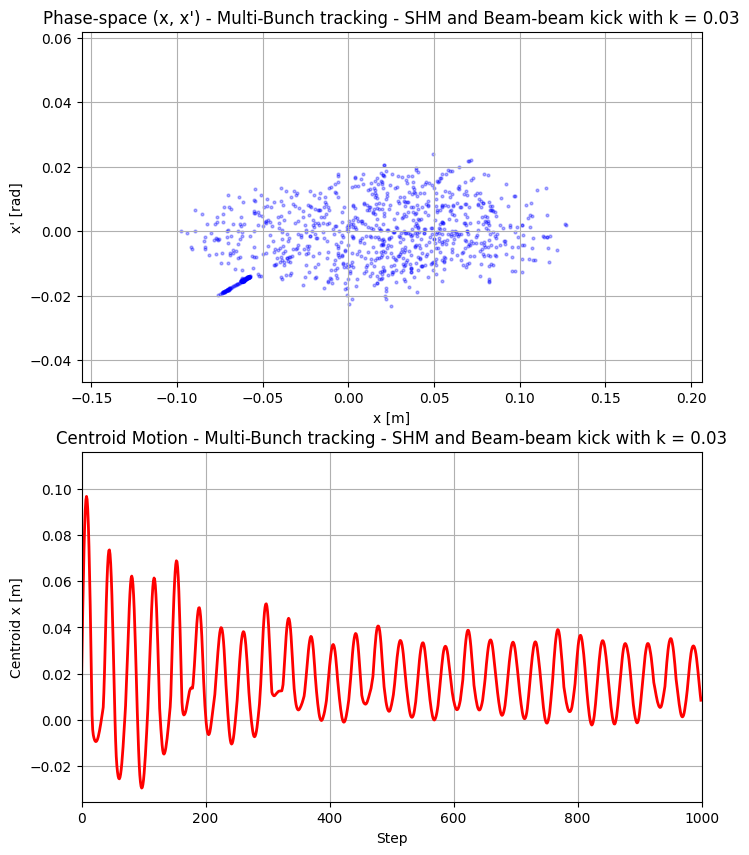

In [5]:
#Animated phase space (x,x') and centroid motion plots:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10))

# Phase space subplot:
ax1.set_xlim(np.min(phase_space_steps), np.max(phase_space_steps))  
ax1.set_ylim(10 * k * np.min(phase_space_steps), 10 * k * np.max(phase_space_steps))
ax1.set_xlabel("x [m]")
ax1.set_ylabel("x' [rad]")
ax1.set_title(f"Phase-space (x, x') - Multi-Bunch tracking - SHM and Beam-beam kick with k = {k}")
ax1.grid(True)
scatter = ax1.scatter([], [], s=4, c='blue', alpha=0.3)

# Centroid subplot
ax2.set_xlim(0, len(centroid))
ax2.set_ylim(min(centroid) * 6/5, max(centroid) * 6/5)
ax2.set_xlabel("Step")
ax2.set_ylabel("Centroid x [m]")
ax2.set_title(f"Centroid Motion - Multi-Bunch tracking - SHM and Beam-beam kick with k = {k}")
ax2.grid(True)
line, = ax2.plot([], [], lw=2, c='red')

# Animation function:
def animate(i):
    # Phase-space DATA:
    data = np.vstack(phase_space_steps[i]).T
    scatter.set_offsets(data)
    
    # Centroid DATA:
    line.set_data(range(i+1), centroid[:i+1])
    
    return scatter, line


# Run animation
from IPython.display import HTML  #Save in html
import matplotlib as mpl  #For big-sized animations 

anim = animation.FuncAnimation(fig, animate, frames=len(centroid), interval=50, blit=True)

mpl.rcParams['animation.embed_limit'] = 100 # [MB] - for big animations
HTML(anim.to_html5_video())

anim.save(filename = "SHM_Beam_Beam_Kick_and_Space_Charge.gif", writer = 'Pillow')


Plots: RMS beam size, emittance, momentum kick:


Calculation of transverse emittance in x-axis for each step

Transverse emittance ε_x is a measure of the phase-space area occupied by the beam in x-x' plane.
It combines the spread in position (x) and angle (xp) and includes their correlations.

In [6]:
emittance_x = []
for step_data in phase_space_steps:
    x   = step_data[0]    # x positions at this step
    xp  = step_data[1]    # x' momenta at this step
    # RMS emittance formula: ε_x = sqrt(<x^2><xp^2> - <x*xp>^2)
    eps = np.sqrt(np.mean(x ** 2) * np.mean(xp ** 2) - np.mean(x * xp) ** 2)
    emittance_x.append(eps)

Plot the phase-space deformation as snapshots:

We plot selected steps to visualize how the phase-space evolves over time.

This is especially interesting to see how beam-beam and space charge deform the distribution.

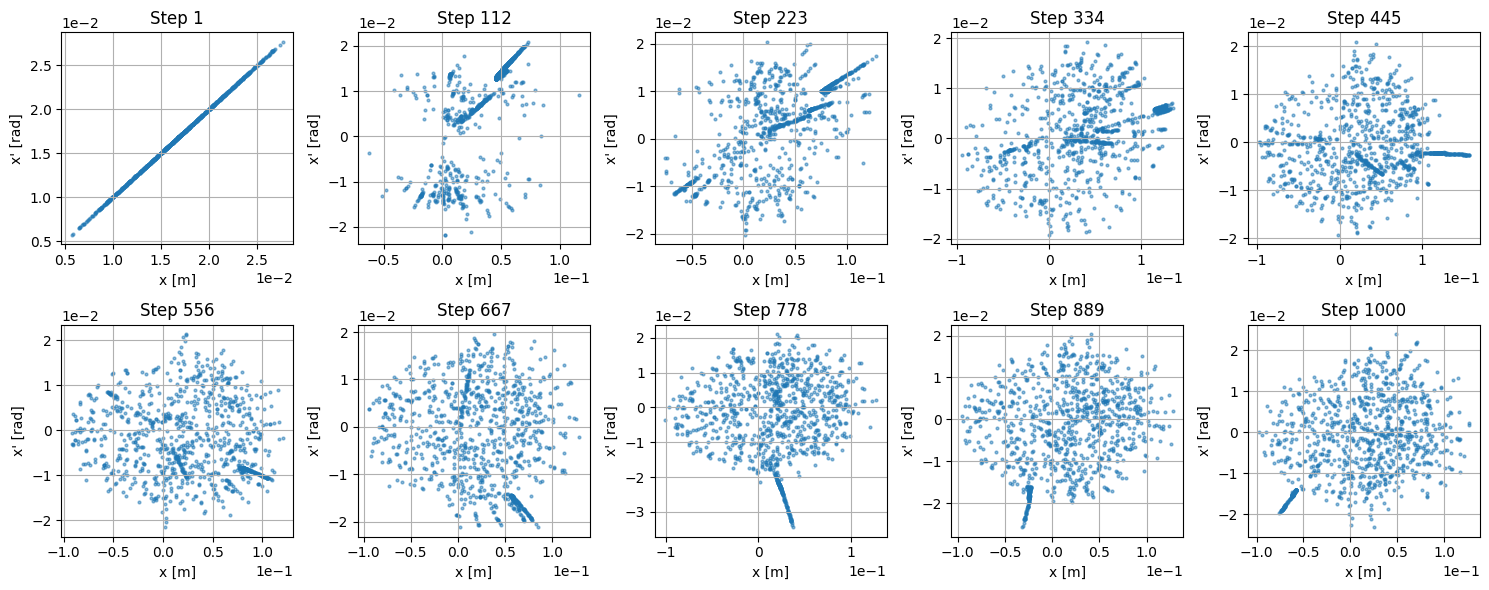

In [7]:
# Here we plot the phase space deformation with space charge in snapshots. 
# If you choose space_charge = False, then the phase space without space charge is depicted:
i = np.array(np.linspace(1, turns, int(turns / ((turns-50) / 10) ))).astype(int) # The number of plots will be shown (custom steps)
figure, axis = plt.subplots(2, 5, figsize=(15, 6))
axis         = axis.flatten()

for s, n in enumerate(i): # s: subplots, n: number of plots
    x, xp = phase_space_steps[n-1]
    axis[s].scatter(x, xp, s = 4, alpha = 0.5)
    axis[s].set_title(f"Step {n}")
    axis[s].set_xlabel("x [m]")
    axis[s].set_ylabel("x' [rad]")
    axis[s].grid(True)

    axis[s].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axis[s].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.show()

Plot emittance growth over time:

This shows how the transverse phase-space area grows due to non-linear forces and space charge.

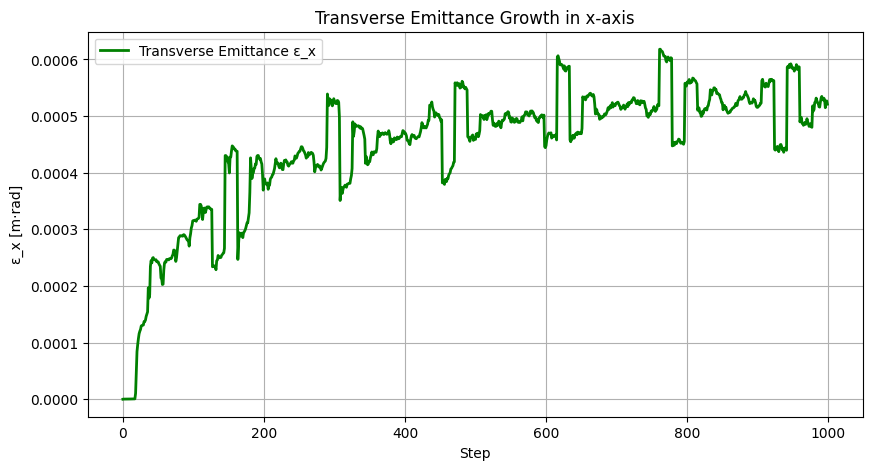

In [8]:
plt.figure(figsize=(10,5))
plt.plot(emittance_x, color='green', lw=2, label='Transverse Emittance ε_x')
plt.xlabel("Step")
plt.ylabel("ε_x [m·rad]")
plt.title("Transverse Emittance Growth in x-axis")
plt.grid(True)
plt.legend()
plt.show()

Plot centroid motion and RMS beam size:

Centroid shows the mean position of the bunch in x. RMS beam size shows the spread of particles around the centroid.

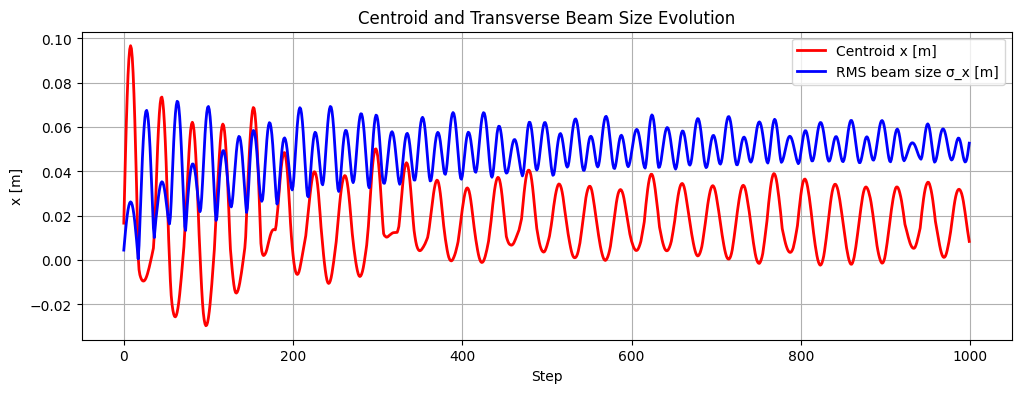

In [9]:
rms_x = [np.std(step[0]) for step in phase_space_steps]

plt.figure(figsize=(12,4))
plt.plot(centroid, label='Centroid x [m]', color='red', lw=2)
plt.plot(rms_x, label='RMS beam size σ_x [m]', color='blue', lw=2)
plt.xlabel("Step")
plt.ylabel("x [m]")
plt.title("Centroid and Transverse Beam Size Evolution")
plt.grid(True)
plt.legend()
plt.show()

Plot average momentum kick per step:

Momentum kick shows how much the transverse momentum changes due to SHM, beam-beam, and space charge. This helps to quantify the net effect of collective forces on the bunch

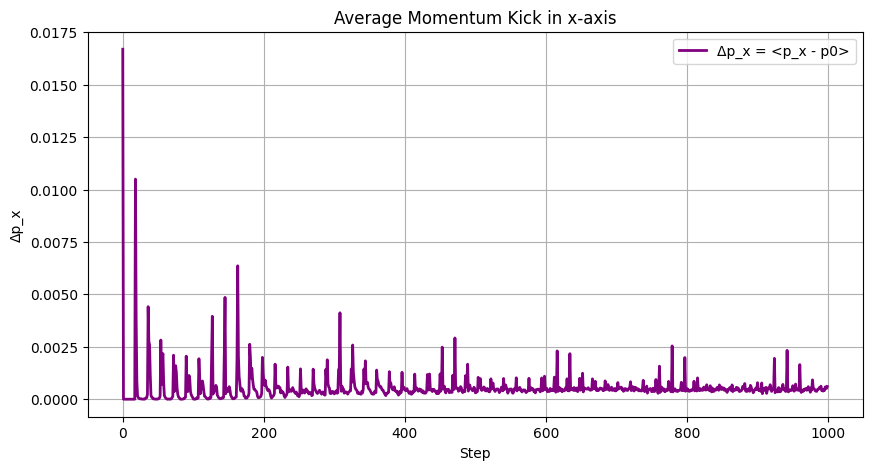

In [10]:
plt.figure(figsize=(10,5))
plt.plot(momentum_kick_steps, color='purple', lw=2, label='Δp_x = <p_x - p0>')
plt.xlabel("Step")
plt.ylabel("Δp_x")
plt.title("Average Momentum Kick in x-axis")
plt.grid(True)
plt.legend()
plt.show()